In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib

In [4]:
img = nib.load('ABIDEII/sub-28726_session_1_task-func-1_desc-mean_bold.nii.gz')

print(img.header.get_xyzt_units())
print(img.shape)
print(img.header.get_zooms())

('mm', 'unknown')
(80, 80, 48)
(3.0, 3.0, 3.0)


numpy.ndarray

In [42]:
mid_slice_x = img.get_fdata()[40, :, :]
print(mid_slice_x.shape)

(80, 48)


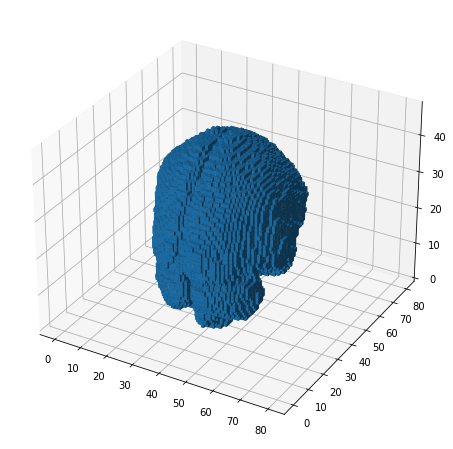

In [43]:
# Note that the transpose the slice (using the .T attribute).
# This is because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the
# second on the y-axis. Also, the origin to "lower", as the data was saved in
# "cartesian" coordinates.

# plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
# plt.xlabel('First axis')
# plt.ylabel('Second axis')
# plt.colorbar(label='Signal intensity')
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
colors = np.empty(img.get_fdata().shape, dtype=object)
ax.voxels(img.get_fdata())

plt.show()

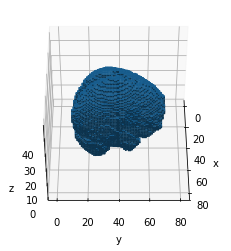

In [44]:
# ROTATING 3D img
# https://stackoverflow.com/questions/42207083/control-angle-of-image-projection-in-3d-matplotlib-graphs
import matplotlib.animation

pi=np.pi
w= np.arange(0,5000,1)

def lorentzian(x,center,width,time,tau):
    return 1.0/((1+((x-center)/width)**2)*width*pi)*np.exp(-time/tau)

centers= [1000.0,2000.0,4000.0]
widths = [100.0,300.0,50.0]

taus=np.zeros(len(widths))

for i in range(0,len(widths),1):
    taus[i] = 1.0/widths[i]

time = np.array([0,0.019,0.033])
B = np.zeros((3,len(w)))
for z in range(0,len(time),1):
    a= np.zeros(len(w))
    for i in range(0,len(centers),1):
        a = a + lorentzian(w,centers[i],widths[i],time[z],taus[i])
    B[z] = a

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# colour = ["purple","green","orange"]
# for i in range(len(time)-1,-1,-1):
ax.voxels(img.get_fdata())

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

#(elev, azim)
ax.view_init(45,0)

phi = np.linspace(0, 2*np.pi)

def update(phi):
    ax.view_init(45, phi*180./np.pi)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=phi)
# ani.save(__file__+".gif", writer='imagemagick', fps=10)
plt.show()

In [49]:
# video of slices
%matplotlib notebook


x = img.get_fdata() # Some array of images
fig = plt.figure()
viewer = fig.add_subplot(111)

plt.ion() # Turns interactive mode on (probably unnecessary)
fig.show() # Initially shows the figure

for i in range(x.T.shape[0]):
    viewer.clear() # Clears the previous image
    viewer.imshow(x.T[i]) # Loads the new image
    plt.pause(.1) # Delay in seconds
    fig.canvas.draw()

# fig = plt.figure()
# viewer = fig.add_subplot(111)
# fig.show()
# for i in range(x.shape[1]):
#     viewer.clear() # Clears the previous image
#     viewer.imshow(x[:,i]) # Loads the new image
#     plt.pause(.1) # Delay in seconds
#     fig.canvas.draw()

<IPython.core.display.Javascript object>

## Importing the data
__Question:__ when there are multiple fMRI resting state for the same person, do we only take one or all of them to have more samples?

In [51]:
import pandas as pd
labels_path = "/home/nap-smasher/Documents/malis-project-autism/ABIDEII/ABIDEII_Composite_Phenotypic.csv"
df_pheno = pd.read_csv(labels_path, encoding="unicode_escape")
selection = df_pheno[(df_pheno['AGE_AT_SCAN '] <= 40) & (df_pheno['FIQ'] >= 80)]    # add check for FIQ = NaN
'''
get only as many males as females and make sure to maintain proportion of autistic and controls
'''
## Total Females-Males
females = selection[selection['SEX'] == 2]
males = selection[selection['SEX'] == 1]
print("females", len(females))
print("males", len(males))
## Autistic Females-Males
females_autistic = females[females['DX_GROUP'] == 1]
males_autistic = males[males['DX_GROUP'] == 1]
males_control = males[males['DX_GROUP'] == 2]
print("females_autistic", len(females_autistic))
print("males_autistic", len(males_autistic))
# therefore we need len(females_autistic) control males and len(females)-len(females_autistic) autistic males
# remove: #males-#autistic_females and #males
ma_to_remove = np.random.choice(males_autistic.index, size=231, replace=False)
mc_to_remove = np.random.choice(males_control.index, size=295, replace=False)
selection = selection.drop(ma_to_remove)
selection = selection.drop(mc_to_remove)
labels = selection[['SUB_ID','DX_GROUP']]
# labels_dict = labels.set_index('SUB_ID').T.to_dict('list')

females 220
males 726
females_autistic 61
males_autistic 370


In [52]:
len(males_autistic)-len(mc_to_remove)

75

In [53]:
len(selection[selection['SEX'] == 1])

200

In [78]:
labels[labels['SUB_ID'] == 28713]

,SUB_ID,DX_GROUP
827,28713,2


In [54]:
import os
import json
import re
data_path = "/home/nap-smasher/Downloads/brain_img_data/"
img_list = []
dict_id_path = {}
for dirpath, dirnames, files in os.walk(data_path):
    for name in files:
        if dirpath.__contains__("session_1/rest_1"):
            img_path = os.path.join(dirpath, name)
            img_list.append(img_path)
            # sub_id = dirpath.split("/")[-3]
            sub_id = re.search(r"\d{5}", dirpath).group()
            # lab = labels.loc[labels['SUB_ID'] == int(sub_id)]
            # lab = lab['DX_GROUP'].value
            # print(f'{lab=}')
            dict_id_path[sub_id] = img_path
img_list = np.array(img_list)
img_list.sort()
# np.save("img_paths", img_list)
with open("img_paths.json", "w") as f:
    json.dump(dict_id_path, f, indent=4)

In [55]:
img_list

array(['/home/nap-smasher/Downloads/brain_img_data/28676/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28677/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28678/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28679/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28680/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28682/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28684/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28685/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28686/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28688/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downloads/brain_img_data/28689/session_1/rest_1/rest.nii.gz',
       '/home/nap-smasher/Downlo

In [68]:
sub_list = list(labels['SUB_ID'])
sub_list.sort()
split = len(sub_list)//3
sub_list1 = sub_list[:split]
sub_list2 = sub_list[split:2*split]
sub_list3 = sub_list[2*split:]
# print(f'{sub_list1[-1]=}')
# print(f'{sub_list2[0]=}', f'{sub_list2[-1]=}')
# print(f'{sub_list3[0]=}')
len(sub_list3)

140

In [70]:
with open("/home/nap-smasher/Downloads/subj_list1.txt", "w") as f:
    f.writelines("%s\n" % i for i in sub_list1)
with open("/home/nap-smasher/Downloads/subj_list2.txt", "w") as f:
    f.writelines("%s\n" % i for i in sub_list2)
with open("/home/nap-smasher/Downloads/subj_list3.txt", "w") as f:
    f.writelines("%s\n" % i for i in sub_list3)

In [17]:
X = [nib.load(img) for img in img_list[:105]]
y = labels.iloc[:,-1]

In [ ]:
# img = dataset[0]
# print(img.header.get_xyzt_units())
# print(img.shape)
# print(img.header.get_zooms())

In [ ]:
# mid_slice_x = img.get_fdata()[40, :, :, 730]
# print(mid_slice_x.shape)

In [ ]:
# plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
# plt.xlabel('First axis')
# plt.ylabel('Second axis')
# plt.colorbar(label='Signal intensity')
# plt.show()


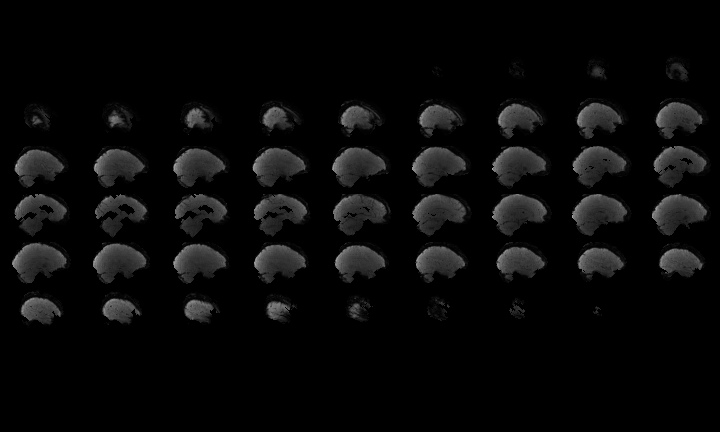
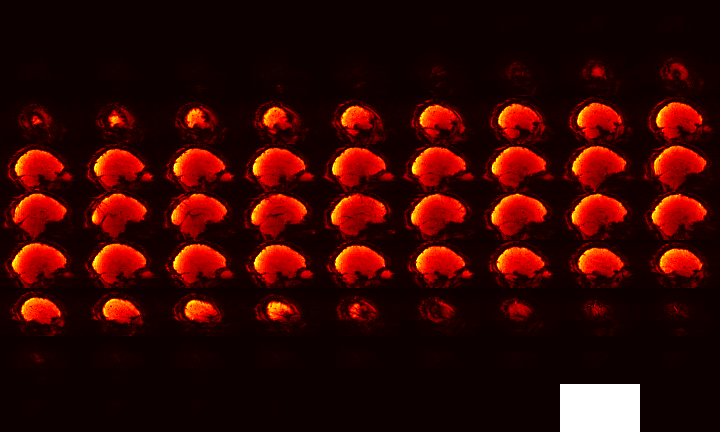

In [2]:
from nilearn import plotting
from nilearn import image as nli

mask_img = nli.load_img('/home/nap-smasher/Downloads/brain_data_processed/output/cpac_singul_pipeline/28678_session_1/func/sub-28678_session_1_task-func-1_space-bold_desc-brain_mask.nii.gz')
bold_img = nli.load_img('/home/nap-smasher/Downloads/brain_data_processed/output/cpac_singul_pipeline/28678_session_1/func/sub-28678_session_1_task-func-1_desc-preproc_bold.nii.gz')

# calculate mean image for the background
mean_func_img = nli.mean_img(bold_img)

plotting.view_img(mean_func_img, bg_img=mean_func_img)

In [3]:
from nilearn.masking import apply_mask

all_timecourses = apply_mask(bold_img, mask_img)
all_timecourses.shape

(947, 46268)

In [4]:
from nilearn.masking import unmask
img_timecourse = unmask(all_timecourses, mask_img)

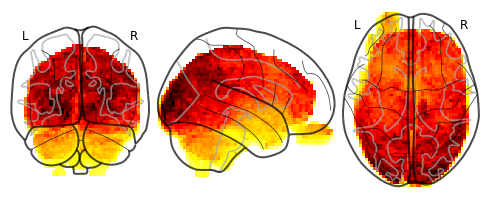

In [6]:
first_volume = nli.image.index_img(img_timecourse, 0)
plotting.plot_glass_brain(first_volume)

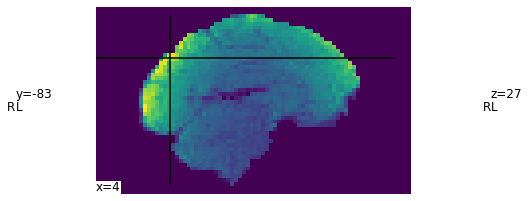

In [14]:
first_slice = first_volume.slicer[40:41,:,:]
plotting.plot_img(first_slice)

In [15]:
img_timecourse.shape

(80, 80, 48, 947)

Following <a href="https://peerherholz.github.io/workshop_weizmann/data/image_manipulation_nilearn.html#let-s-create-a-mean-image">tutorial</a>

Comparing mean image computed with nilearn from preprocessed fMRI (#1) and mean image from file

In [ ]:
data_path = r"/home/nap-smasher/Downloads/brain_data_processed/output/cpac_singul_pipeline/"
subj_data_paths = os.listdir(data_path)
subj_ids_processed = [re.search(r"[0-9]{5}",p).group() for p in subj_data_paths]

# choose a sample of images for testing the code
sample_size = 5
chosen_ixs = np.random.choice(np.arange(len(subj_data_paths)), size=sample_size, replace=False)
chosen_samples = np.take(subj_data_paths, chosen_ixs)
# chosen_labels = np.take(labels, chosen_ixs)
preproc_bolds = [nib.load(data_path+subj+"/func/sub-"+subj+"_task-func-1_desc-preproc_bold.nii.gz") for subj in chosen_samples]
masks = [nib.load(data_path+subj+"/func/sub-"+subj+"_task-func-1_space-bold_desc-brain_mask.nii.gz") for subj in chosen_samples]
mean_bolds = [nib.load(data_path+subj+"/func/sub-"+subj+"_task-func-1_desc-mean_bold.nii.gz") for subj in chosen_samples]

(80, 80, 48)



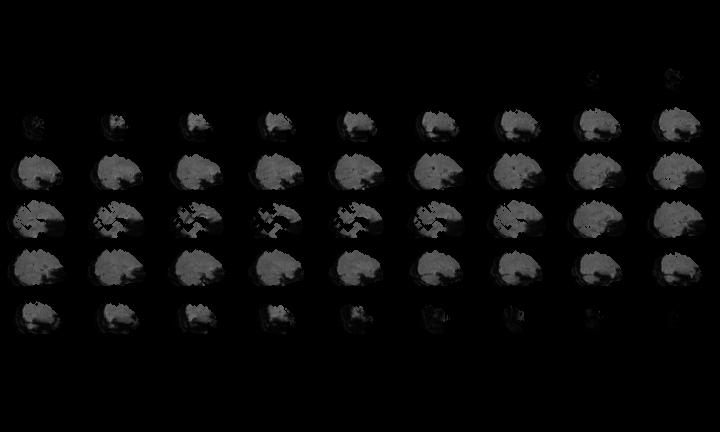
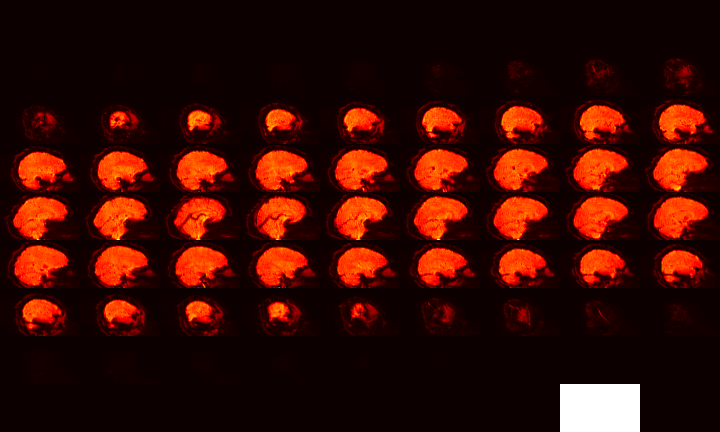

In [15]:
mean = nli.mean_img(preproc_bolds[0])
print(mean.shape)
plotting.view_img(mean, bg_img=mean)

(80, 80, 48)



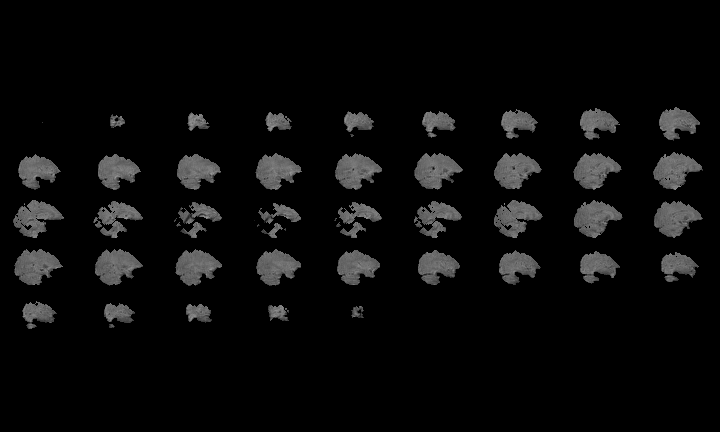
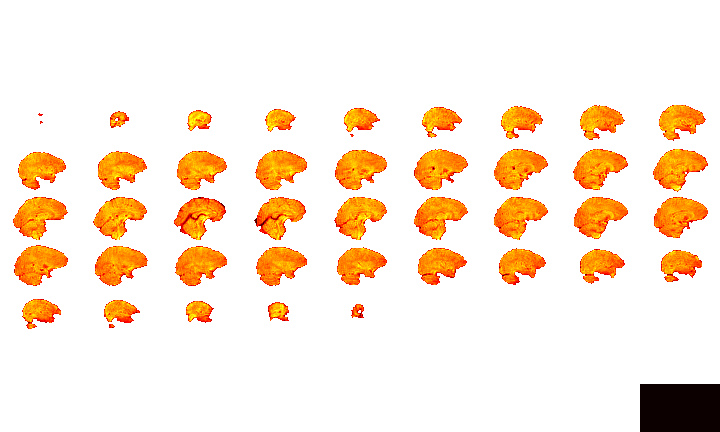

In [16]:
print(mean_bolds[0].shape)
plotting.view_img(mean_bolds[0], bg_img=mean_bolds[0])

#### **Mean image from file looks not centered!**
Proceeding with computed mean

Keep voxels that have a value that is higher than 95% of all voxels.


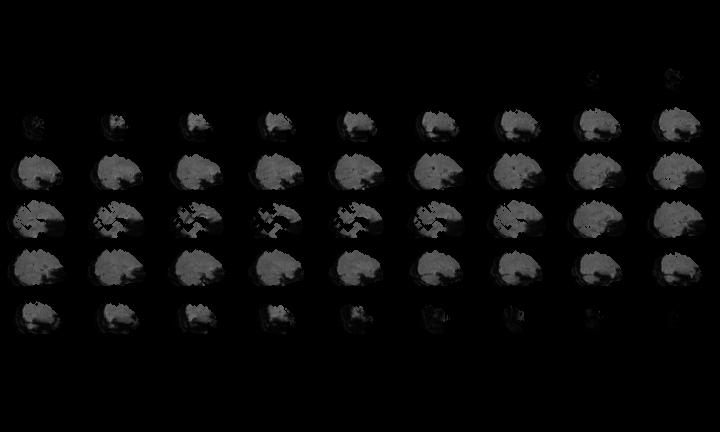
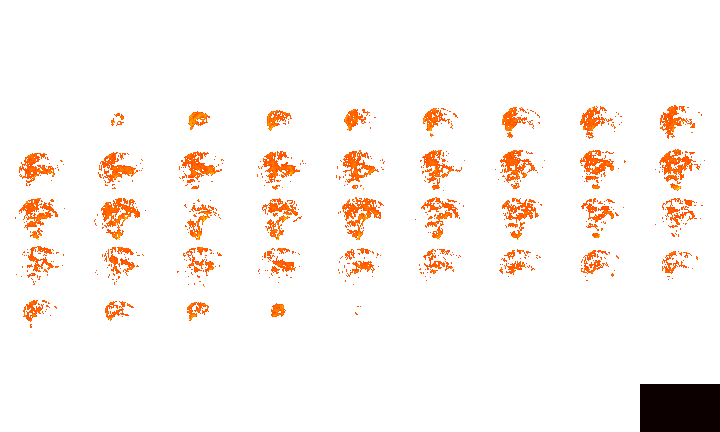

In [17]:
thr = nli.threshold_img(mean, threshold='95%')
plotting.view_img(thr, bg_img=mean)

In [18]:
# thr_mean_from_file = nli.threshold_img(mean_bolds[0], threshold='95%')
# plotting.view_img(thr, bg_img=mean_bolds[0])

Only keep those voxels that are in regions/clusters that are bigger than 1000mm^3.

In [19]:
voxel_size = np.prod(thr.header['pixdim'][1:4])  # Size of 1 voxel in mm^3
voxel_size

26.999994

Create a mask with those clusters

In [20]:
from nilearn.regions import connected_regions
cluster = connected_regions(thr, min_region_size=1000. / voxel_size, smoothing_fwhm=1)[0]
mask = nli.math_img('np.mean(img,axis=3) > 0', img=cluster)

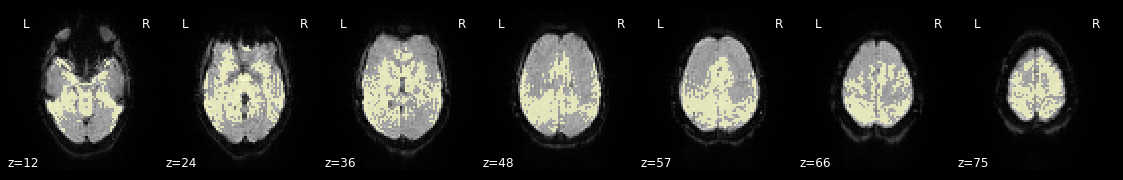

In [21]:
# visualize on top of a frame from the fMRI
from nilearn.plotting import plot_roi
frame = nli.image.index_img(preproc_bolds[0], 20)
plotting.plot_roi(mask, bg_img=frame, display_mode='z', dim=-.5, cmap='magma_r');

Apply mask to the original functional image and extract the mean of the temporal signal.

all_timecourses.shape=(947, 14609)


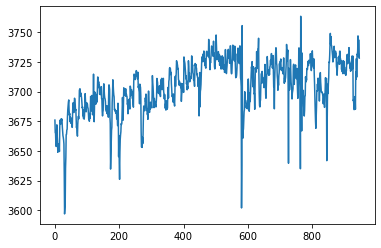

In [22]:
from nilearn.masking import apply_mask
import pylab as plt

all_timecourses = apply_mask(preproc_bolds[0], mask)
print(f'{all_timecourses.shape=}')

# mean of temporal signal - what do we need this for?
mean_timecourse = all_timecourses.mean(axis=1)
plt.plot(mean_timecourse)